In [2]:
!pip install seaborn

In [3]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import boto3

# 프로젝트 경로 설정
project_dir = Path.cwd()
data_dir = project_dir / "data"
data_dir.mkdir(exist_ok=True)

print(f"Project: {project_dir}")
print(f"Data:    {data_dir}")

Project: /home/ec2-user/SageMaker/kunops-staff
Data:    /home/ec2-user/SageMaker/kunops-staff/data


In [4]:
# Seaborn에서 Titanic 데이터 로드
df = sns.load_dataset('titanic')

print(f"전체 데이터: {len(df)} rows, {len(df.columns)} columns")
print(f"컬럼: {list(df.columns)}")
df.head()

전체 데이터: 891 rows, 15 columns
컬럼: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


사망(0): 549 (61.6%)
생존(1): 342 (38.4%)


<Axes: title={'center': 'Survived Distribution'}, xlabel='survived'>

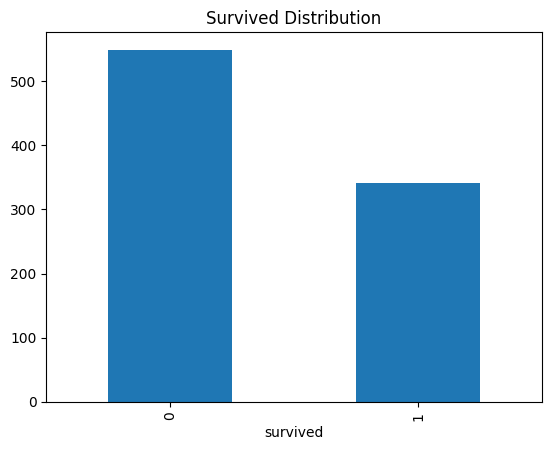

In [5]:
# 타겟 분포 확인
survived_counts = df['survived'].value_counts()

print(f"사망(0): {survived_counts[0]} ({survived_counts[0]/len(df)*100:.1f}%)")
print(f"생존(1): {survived_counts[1]} ({survived_counts[1]/len(df)*100:.1f}%)")

df['survived'].value_counts().plot(kind='bar', title='Survived Distribution')

In [6]:
# Train(70%) / Validation(20%) / Test(10%) 분할

# 1단계: train+val (90%) vs test (10%)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['survived']
)

# 2단계: train (70%) vs validation (20%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.222,  # 20/90 ≈ 22.2%
    random_state=42,
    stratify=train_val_df['survived']
)

print(f"Train:      {len(train_df)} rows ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} rows ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test:       {len(test_df)} rows ({len(test_df)/len(df)*100:.1f}%)")

Train:      623 rows (69.9%)
Validation: 178 rows (20.0%)
Test:       90 rows (10.1%)


In [7]:
# CSV 파일 저장
train_path = data_dir / "train.csv"
val_path = data_dir / "validation.csv"
test_path = data_dir / "test.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✅ {train_path}")
print(f"✅ {val_path}")
print(f"✅ {test_path}")

✅ /home/ec2-user/SageMaker/kunops-staff/data/train.csv
✅ /home/ec2-user/SageMaker/kunops-staff/data/validation.csv
✅ /home/ec2-user/SageMaker/kunops-staff/data/test.csv


In [8]:
# 결과 요약
print("=" * 50)
print("데이터 분할 완료")
print("=" * 50)
print(f"\nTrain:      {len(train_df)} samples (survived: {train_df['survived'].sum()})")
print(f"Validation: {len(val_df)} samples (survived: {val_df['survived'].sum()})")
print(f"Test:       {len(test_df)} samples (survived: {test_df['survived'].sum()})")

# 저장된 파일 확인
!ls -la {data_dir}

데이터 분할 완료

Train:      623 samples (survived: 239)
Validation: 178 samples (survived: 68)
Test:       90 samples (survived: 35)
total 68
drwxrwxr-x 2 ec2-user ec2-user  4096 Jan 30 04:49 .
drwxrwxr-x 8 ec2-user ec2-user  4096 Jan 31 05:57 ..
-rw-rw-r-- 1 ec2-user ec2-user  5839 Jan 31 05:59 test.csv
-rw-rw-r-- 1 ec2-user ec2-user 39916 Jan 31 05:59 train.csv
-rw-rw-r-- 1 ec2-user ec2-user 11463 Jan 31 05:59 validation.csv


In [11]:
# boto3 세션 생성
AWS_REGION = "us-east-1"
S3_BUCKET = "kunops-staff-exercise"
S3_DATA_PREFIX = "data"
S3_MODEL_PREFIX = "models"
S3_DATA_PATH = f"s3://{S3_BUCKET}/{S3_DATA_PREFIX}"

boto_session = boto3.Session(region_name=AWS_REGION)
s3_client = boto_session.client("s3")

# S3에 데이터가 있는지 확인
print(f"Checking S3 path: {S3_DATA_PATH}")
print("="*60)

try:
    response = s3_client.list_objects_v2(
        Bucket=S3_BUCKET,
        Prefix=S3_DATA_PREFIX,
        MaxKeys=20
    )
    
    if "Contents" in response:
        print("Files found in S3:")
        for obj in response["Contents"]:
            print(f"  - {obj['Key']} ({obj['Size']:,} bytes)")
    else:
        print("⚠️ No files found. You need to upload data first.")
        print("   Run the next cell to upload data from local.")
except Exception as e:
    print(f"❌ Error: {e}")

Checking S3 path: s3://kunops-staff-exercise/data
Files found in S3:
  - data/test.csv (5,839 bytes)
  - data/train.csv (39,916 bytes)
  - data/validation.csv (11,463 bytes)


In [15]:
# (선택) 로컬 데이터를 S3에 업로드
# 이미 S3에 데이터가 있으면 이 셀은 스킵
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

UPLOAD_DATA = False  # True로 변경하면 업로드 실행

if UPLOAD_DATA:
    from sagemaker.s3 import S3Uploader
    import sagemaker
    
    sm_session = sagemaker.Session(boto_session=boto_session)
    
    # 로컬 데이터 파일들
    data_files = ["train.csv", "validation.csv", "test.csv"]
    
    for file_name in data_files:
        local_path = DATA_DIR / file_name
        if local_path.exists():
            s3_uri = S3Uploader.upload(
                local_path=str(local_path),
                desired_s3_uri=S3_DATA_PATH,
                sagemaker_session=sm_session
            )
            print(f"✅ Uploaded: {file_name} -> {s3_uri}")
        else:
            print(f"❌ File not found: {local_path}")
else:
    print("Data upload skipped. Set UPLOAD_DATA=True to upload.")

Data upload skipped. Set UPLOAD_DATA=True to upload.
